In [19]:
train_path = '/storage/coda1/p-dsgt_clef2025/0/shared/exist/latest/EXIST_2025_Videos_Dataset/train_test/train_df.csv'
val_path = '/storage/coda1/p-dsgt_clef2025/0/shared/exist/latest/EXIST_2025_Videos_Dataset/train_test/test_df.csv'

import pandas as pd
import numpy as np

train_data_source = pd.read_csv(train_path)
train_data = train_data_source[['text', 'target']]

val_data_source = pd.read_csv(val_path)
val_data = val_data_source[['text', 'target']]
val_data

,text,target
0,gender identity ≠ sexual orientation raising_...,0
1,"he looked so happy, love bint<3 ""\n\n""clean th...",0
2,"him in this film red_heart ""why is this some...",0
3,"i only know 3 notes but i’m practicing! him ""...",1
4,frowning_face_with_open_mouth what? frowning_...,0
...,...,...
195,let’s stir some beef not all men are bad drive...,1
196,i just miss red lighting and catching someone’...,0
197,married 3 times! well it's a one for the money...,1
198,"ice cold baby. heart_on_fire ""cold blooded ...",0


In [20]:
# Example
train_path = '/storage/coda1/p-dsgt_clef2025/0/shared/exist/latest/EXIST_2025_Videos_Dataset/train_test/train_df.csv'

train_texts = train_data['text'].tolist()
train_labels =  train_data['target'].tolist()

test_texts = val_data['text'].tolist()
test_labels =  val_data['target'].tolist()



In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

In [22]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors='pt',
        max_length=512
    )

train_encodings = tokenize(train_texts)
test_encodings = tokenize(test_texts)


In [28]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

In [29]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [30]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = RobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=len(set(train_labels)))
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
epochs = 3
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        correct += (preds == batch['labels']).sum().item()
        total += batch['labels'].size(0)

        loop.set_postfix(loss=loss.item())

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


Epoch 1: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=0.312]


Epoch 1 - Loss: 0.6739, Accuracy: 0.6038


Epoch 2: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=0.375]


Epoch 2 - Loss: 0.5514, Accuracy: 0.7225


Epoch 3: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=0.382]

Epoch 3 - Loss: 0.4172, Accuracy: 0.8200


In [32]:
model.eval()
test_preds, test_targets = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(batch['labels'].cpu().numpy())

test_accuracy = accuracy_score(test_targets, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")


Evaluating: 100%|██████████| 25/25 [00:05<00:00,  4.24it/s]

Test Accuracy: 0.7850


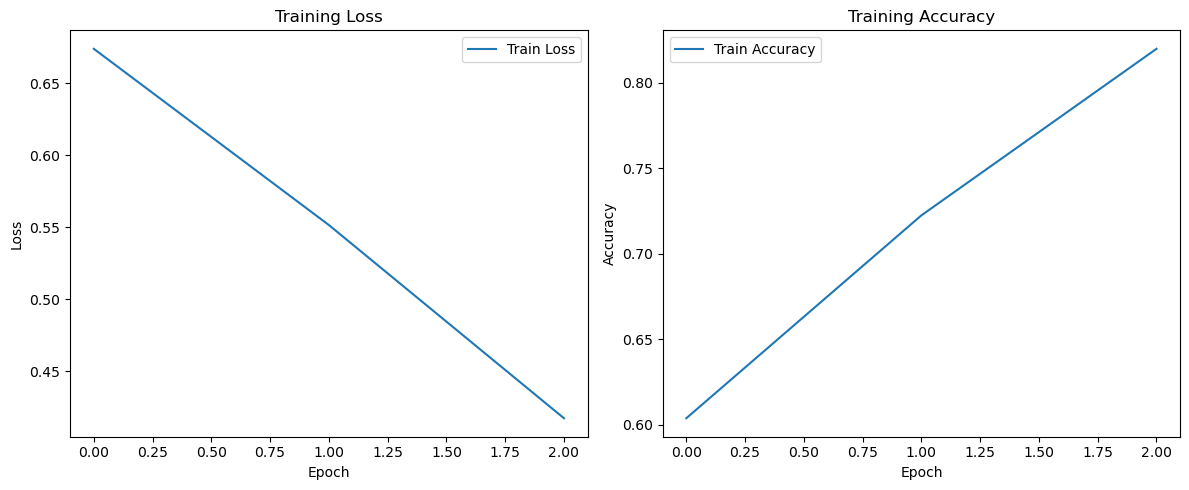

In [33]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
